# Bounding Box Visualization

training dataset을 model에 넣어서 나온 결과와 training dataset의 ground truth value를 비교할 수 있는 코드를 작성했습니다. faster_rcnn_torchvision_eval.csv는 faster_rcnn_torchvision_eval.ipynb를 실행시켜 나온 csv파일입니다.

In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np

import os

In [2]:
GT_JSON = '/opt/ml/detection/dataset/test_kfold.json'
PRED_CSV = '/opt/ml/detection/EfficientDet/submission_29.csv'

labels = {0:'General trash',1:'Paper',2:'Paper pack',3:'Metal',4:'Glass',5:'Plastic',6:'Styrofoam',7:'Plastic bag',8:'Battery',9:'Clothing'}
label_colors = {0:'black',1:'darkcyan',2:'sienna',3:'gray',4:'navy',5:'chartreuse',6:'firebrick',7:'seagreen',8:'darkorchid',9:'olivedrab'}

data_dir = '/opt/ml/detection/dataset'

# load prediction
pred_df = pd.read_csv(PRED_CSV)

In [3]:
coco = COCO(GT_JSON)
gt=[]
for image_id in coco.getImgIds():
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['df_id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    file_name = image_info['file_name']
    id_gt =[]
    for annotation in annotation_info_list:
        id_gt.append([annotation['category_id'], file_name,
                   float(annotation['bbox'][0]),
                   float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                   float(annotation['bbox'][1]),
                   float(annotation['bbox'][1]) + float(annotation['bbox'][3])])
    gt.append(id_gt)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
def get_data_model(ind,threshold=0.5):
    data = pred_df.loc[ind]
    img_id = data['image_id']
    #import pdb; pdb.set_trace()
    if pd.isna(data['PredictionString']):
        return img_id, np.array([])
    box_list = np.array(data['PredictionString'].split())
    if len(box_list)!=1:
        box_list = box_list.reshape(-1,6)
    vis =[]
    for box in box_list:
        if float(box[1]) > threshold:
            vis.append(box.tolist())
    return img_id, np.array(vis)

In [5]:
def vis_img(img_id, vis_model, vis_GT):
    img_path = os.path.join(data_dir, img_id)
    im = np.array(Image.open(img_path), dtype=np.uint8)
    fig, ax = plt.subplots(1,2,figsize=(20,15))
    ax[0].imshow(im)
    ax[0].set_title("Prediction", fontsize = 25)
    for bbox in vis_model:
        rect = patches.Rectangle((float(bbox[2]), float(bbox[3])), float(bbox[4])-float(bbox[2]),float(bbox[5])-float(bbox[3]), linewidth=2, edgecolor=label_colors[int(bbox[0])], facecolor='none')
        ax[0].text(float(bbox[2]),float(bbox[3]),s=labels[int(bbox[0])],
                color='white',
                backgroundcolor=label_colors[int(bbox[0])],
                )
        ax[0].add_patch(rect)
    ax[1].imshow(im)
    ax[1].set_title("Ground Truth", fontsize = 25)
    for bbox in vis_GT:
        rect = patches.Rectangle((float(bbox[2]), float(bbox[4])), float(bbox[3])-float(bbox[2]),float(bbox[5])-float(bbox[4]), linewidth=2, edgecolor=label_colors[int(bbox[0])], facecolor='none')
        ax[1].text(float(bbox[2]),float(bbox[4]),s=labels[int(bbox[0])],
                color='white',
                backgroundcolor=label_colors[int(bbox[0])],
                )
        ax[1].add_patch(rect)
    plt.show()
    return img_path

In [6]:
ind = [x for x in range(4000)]
i = iter(enumerate(ind))

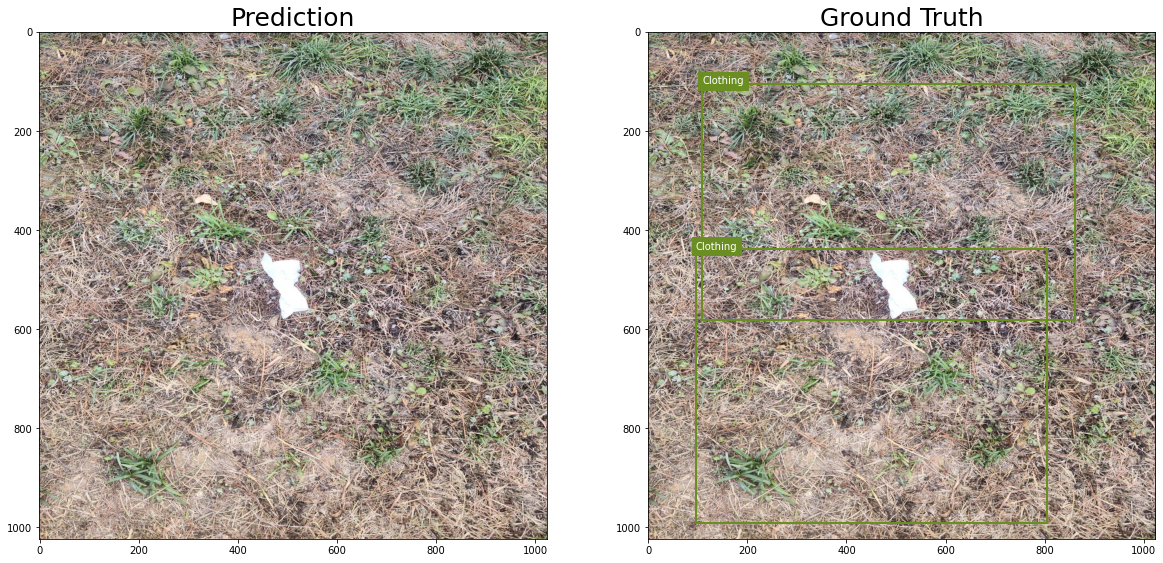

'/opt/ml/detection/dataset/train/0011.jpg'

In [7]:
idx = next(i)[0]
img_id, vis_model = get_data_model(idx,threshold=0.5)
vis_img(img_id, vis_model, np.array(gt[idx]))
#계속해서 실행하면 다른 image들을 볼 수 있습니다.